In [2]:
import os
import torch
import torchvision
import timm

import matplotlib.pyplot as plt
import numpy as np

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from PIL import Image
from tqdm import tqdm

In [3]:
if torch.backends.mps.is_available():
    device = torch.device('mps')
elif torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print("Using device: ", device)

Using device:  cuda


In [4]:
def extract_class_id(image_name):
    """
    Image name example:
    0_1_BMW_X3_156 => 1
    2_4_Volkswagen_Polo_3471 => 24
    8_6_Ford_Focus_11936 => 86
    """
    image_name = image_name.split("/")[-1]
    image_name = image_name.split(".")[0]
    return int(image_name.split("_")[0] + image_name.split("_")[1])

In [5]:
#Load dataset
data_dir = '../../data/dataset'
#Set output path
output_path = "../../outputs/inceptionv4_2_steps_data_augmentation"
if not os.path.exists(output_path):
    os.makedirs(output_path)

In [6]:
items_per_class = 10
train_files = []
val_files = []
test_files = []

class_files = {}
for file in os.listdir(data_dir):
    class_id = extract_class_id(file)
    if class_id not in class_files:
        class_files[class_id] = []
    class_files[class_id].append(file)

for class_id in class_files:
    np.random.shuffle(class_files[class_id])
    test_files += class_files[class_id][:items_per_class]   
    val_files += class_files[class_id][items_per_class:2*items_per_class]
    train_files += class_files[class_id][2*items_per_class:]       
    

#Check if there is not overlap between the sets
assert len(set(train_files).intersection(set(val_files))) == 0
assert len(set(train_files).intersection(set(test_files))) == 0
assert len(set(val_files).intersection(set(test_files))) == 0

print(len(train_files), len(val_files), len(test_files))

8065 960 960


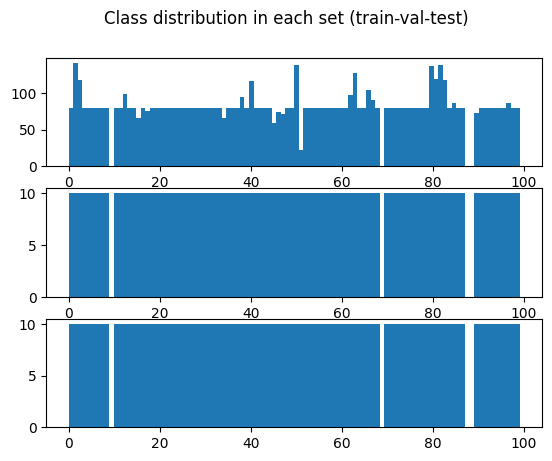

In [7]:
#Display class distribution in each set
train_class_distribution = [extract_class_id(file) for file in train_files]
val_class_distribution = [extract_class_id(file) for file in val_files]
test_class_distribution = [extract_class_id(file) for file in test_files]


fig, axs = plt.subplots(3)
fig.suptitle('Class distribution in each set (train-val-test)')
axs[0].hist(train_class_distribution, bins=100)
axs[1].hist(val_class_distribution, bins=100)
axs[2].hist(test_class_distribution, bins=100)
plt.savefig(os.path.join(output_path, "class_distribution.png"))

In [8]:
class Car_Dataset(Dataset):
    def __init__(self, data_dir, files, split = "train"):
        self.data_dir = data_dir
        self.data = files

        if split == "train":
            self.transform = transforms.Compose([
                transforms.Resize(299),
                transforms.CenterCrop(299),
                transforms.RandomHorizontalFlip(),
                transforms.RandomRotation(10),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225] )
            ])
        else:
            self.transform = transforms.Compose([
                transforms.Resize(299),
                transforms.CenterCrop(299),
                transforms.ToTensor(),            
                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225] )
                ])
    
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        file = self.data[idx]
        label = file.split('_')[0] + file.split('_')[1]
        label = int(label)
        label = torch.eye(100)[label]
        
        img = Image.open(os.path.join(self.data_dir, file)).convert('RGB')
        img = self.transform(img)

        return {"image" : img, "label" : label}

In [9]:
train_dataset = Car_Dataset(data_dir, train_files, split = "train")
val_dataset = Car_Dataset(data_dir, val_files, split = "val")
test_dataset = Car_Dataset(data_dir, test_files, split = "test")

In [10]:
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=4, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=True)

In [11]:
#load model inceptionv4
model = timm.create_model('inception_v4', pretrained=True, num_classes=100).to(device)
for param in model.parameters():
    param.requires_grad = False

model.safetensors: 100%|██████████| 171M/171M [00:02<00:00, 58.0MB/s] 
c:\Users\cleme\AppData\Local\Programs\Python\Python310\lib\site-packages\huggingface_hub\file_download.py:149: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\cleme\.cache\huggingface\hub\models--timm--inception_v4.tf_in1k. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [12]:
def evaluate(dataloader, model, loss_fn):
    model.eval()
    predicted_labels = []
    true_labels = []
    losses = []
    with torch.no_grad():
        for data in dataloader:
            X, y = data['image'], data['label']
            pred = model(X.to(device))
            loss = loss_fn(pred, y.to(device))
            predicted_labels.extend(pred.argmax(1).tolist())
            true_labels.extend(y.argmax(1).tolist())
            losses.append(loss.item())
    
    return np.array(predicted_labels), np.array(true_labels), np.mean(losses)

In [13]:
def train_loop(train_loader, val_loader, model, loss_fn, optimizer, n_epoch, patience=5):
    training_losses = []
    validation_losses = []
    training_accuracies = []
    validation_accuracies = []
    print("Training model...")
    best_val_metric = 0
    patience_counter = 0
    best_model = model
    for epoch in tqdm(range(n_epoch)):
        model.train()
        for data in train_loader:
            X, y = data['image'], data['label']
            pred = model(X.to(device))
            loss = loss_fn(pred, y.to(device))        
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        predicted_labels, true_labels, train_loss = evaluate(train_loader, model, loss_fn)
        print("Epoch: ", epoch, " Training Loss: ", train_loss)
        print("Epoch: ", epoch, " Training Accuracy: ", np.mean(predicted_labels == true_labels))
        training_losses.append(train_loss)
        training_accuracies.append(np.mean(predicted_labels == true_labels))
        
        predicted_labels, true_labels, val_loss = evaluate(val_loader, model, loss_fn)
        print("Epoch: ", epoch, " Validation Loss: ", val_loss)
        print("Epoch: ", epoch, " Validation Accuracy: ", np.mean(predicted_labels == true_labels))
        validation_losses.append(val_loss)
        validation_accuracies.append(np.mean(predicted_labels == true_labels))

        if np.mean(predicted_labels == true_labels) > best_val_metric:
            best_val_metric = np.mean(predicted_labels == true_labels)
            best_model = model
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter == patience:
                print("Early stopping...")
                break

    #Save model
    return best_model, training_losses, validation_losses, training_accuracies, validation_accuracies

In [14]:
for param in model.parameters():
    param.requires_grad = True
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0001)
print("Step 2 training")
step2_best_model, step2_training_losses, step2_validation_losses, step2_training_accuracies, step2_validation_accuracies = train_loop(train_dataloader, val_dataloader, model, loss_fn, optimizer, 100, 10)
torch.save(step2_best_model.state_dict(), os.path.join(output_path, "step2_model.pth"))

Step 2 training
Training model...


  0%|          | 0/100 [00:00<?, ?it/s]c:\Users\cleme\AppData\Local\Programs\Python\Python310\lib\site-packages\PIL\Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch:  0  Training Loss:  2.0608146229207547
Epoch:  0  Training Accuracy:  0.39429634221946686


  1%|          | 1/100 [08:17<13:41:31, 497.89s/it]

Epoch:  0  Validation Loss:  2.3220170638213555
Epoch:  0  Validation Accuracy:  0.33541666666666664
Epoch:  1  Training Loss:  1.0161560069500428
Epoch:  1  Training Accuracy:  0.6522008679479231


  2%|▏         | 2/100 [16:39<13:36:25, 499.86s/it]

Epoch:  1  Validation Loss:  1.371999480513235
Epoch:  1  Validation Accuracy:  0.5520833333333334
Epoch:  2  Training Loss:  1.8587952943601913
Epoch:  2  Training Accuracy:  0.6982021078735275


  3%|▎         | 3/100 [24:58<13:27:51, 499.71s/it]

Epoch:  2  Validation Loss:  1.061577239628726
Epoch:  2  Validation Accuracy:  0.68125
Epoch:  3  Training Loss:  0.5466642279968593
Epoch:  3  Training Accuracy:  0.8188468691878488


  4%|▍         | 4/100 [33:18<13:19:44, 499.84s/it]

Epoch:  3  Validation Loss:  0.9606437684615988
Epoch:  3  Validation Accuracy:  0.7375
Epoch:  4  Training Loss:  0.42253749930288037
Epoch:  4  Training Accuracy:  0.8550526968381897


  5%|▌         | 5/100 [41:38<13:11:33, 499.93s/it]

Epoch:  4  Validation Loss:  0.7866141328961628
Epoch:  4  Validation Accuracy:  0.7677083333333333
Epoch:  5  Training Loss:  0.3529128796075291
Epoch:  5  Training Accuracy:  0.886050836949783


  6%|▌         | 6/100 [49:58<13:03:03, 499.82s/it]

Epoch:  5  Validation Loss:  0.8465139787736268
Epoch:  5  Validation Accuracy:  0.7802083333333333
Epoch:  6  Training Loss:  0.27416871414803523
Epoch:  6  Training Accuracy:  0.9055176689398636


  7%|▋         | 7/100 [58:24<12:57:47, 501.80s/it]

Epoch:  6  Validation Loss:  0.7818356594867472
Epoch:  6  Validation Accuracy:  0.7947916666666667
Epoch:  7  Training Loss:  0.629048435141839
Epoch:  7  Training Accuracy:  0.8400495970241786


  8%|▊         | 8/100 [1:06:41<12:47:11, 500.35s/it]

Epoch:  7  Validation Loss:  0.9802284393133703
Epoch:  7  Validation Accuracy:  0.7770833333333333
Epoch:  8  Training Loss:  0.2034047881190962
Epoch:  8  Training Accuracy:  0.9288282703037818


  9%|▉         | 9/100 [1:14:57<12:36:59, 499.11s/it]

Epoch:  8  Validation Loss:  0.7524650450613516
Epoch:  8  Validation Accuracy:  0.8020833333333334
Epoch:  9  Training Loss:  0.21482055367134348
Epoch:  9  Training Accuracy:  0.9313081215127093


 10%|█         | 10/100 [1:23:13<12:27:14, 498.16s/it]

Epoch:  9  Validation Loss:  0.7191547779202987
Epoch:  9  Validation Accuracy:  0.8125
Epoch:  10  Training Loss:  0.2751649351388279
Epoch:  10  Training Accuracy:  0.9186608803471792


 11%|█         | 11/100 [1:31:30<12:18:14, 497.69s/it]

Epoch:  10  Validation Loss:  0.7914037230732068
Epoch:  10  Validation Accuracy:  0.809375
Epoch:  11  Training Loss:  0.2393959892675873
Epoch:  11  Training Accuracy:  0.9311841289522629


 12%|█▏        | 12/100 [1:39:47<12:09:24, 497.32s/it]

Epoch:  11  Validation Loss:  0.8424074071817993
Epoch:  11  Validation Accuracy:  0.81875
Epoch:  12  Training Loss:  0.22139217807620706
Epoch:  12  Training Accuracy:  0.936887786732796


 13%|█▎        | 13/100 [1:48:03<12:00:35, 496.96s/it]

Epoch:  12  Validation Loss:  0.6920038763668097
Epoch:  12  Validation Accuracy:  0.8375
Epoch:  13  Training Loss:  0.19355610286375494
Epoch:  13  Training Accuracy:  0.9407315561066336


 14%|█▍        | 14/100 [1:56:14<11:49:50, 495.24s/it]

Epoch:  13  Validation Loss:  0.7146378562197422
Epoch:  13  Validation Accuracy:  0.84375
Epoch:  14  Training Loss:  0.15644319113477112
Epoch:  14  Training Accuracy:  0.9518908865468072


 15%|█▌        | 15/100 [2:03:57<11:27:48, 485.52s/it]

Epoch:  14  Validation Loss:  0.7839272589225923
Epoch:  14  Validation Accuracy:  0.83125
Epoch:  15  Training Loss:  0.14885005452928
Epoch:  15  Training Accuracy:  0.9521388716677


 16%|█▌        | 16/100 [2:11:40<11:10:12, 478.72s/it]

Epoch:  15  Validation Loss:  0.7281009328503653
Epoch:  15  Validation Accuracy:  0.8427083333333333
Epoch:  16  Training Loss:  3.738447788922329
Epoch:  16  Training Accuracy:  0.8679479231246126


 17%|█▋        | 17/100 [2:19:23<10:55:41, 474.00s/it]

Epoch:  16  Validation Loss:  1.5488407200924474
Epoch:  16  Validation Accuracy:  0.80625
Epoch:  17  Training Loss:  0.1835563146662435
Epoch:  17  Training Accuracy:  0.9533787972721637


 18%|█▊        | 18/100 [2:27:06<10:43:15, 470.67s/it]

Epoch:  17  Validation Loss:  0.8863300803849266
Epoch:  17  Validation Accuracy:  0.83125
Epoch:  18  Training Loss:  0.7439696375128948
Epoch:  18  Training Accuracy:  0.9243645381277124


 19%|█▉        | 19/100 [2:34:49<10:32:13, 468.31s/it]

Epoch:  18  Validation Loss:  1.5847776399415616
Epoch:  18  Validation Accuracy:  0.8052083333333333
Epoch:  19  Training Loss:  0.14051780124790333
Epoch:  19  Training Accuracy:  0.9616862988220707


 20%|██        | 20/100 [2:42:32<10:22:20, 466.76s/it]

Epoch:  19  Validation Loss:  0.7273408068668483
Epoch:  19  Validation Accuracy:  0.8385416666666666
Epoch:  20  Training Loss:  0.22017004837700702
Epoch:  20  Training Accuracy:  0.943831370117793


 21%|██        | 21/100 [2:50:15<10:13:04, 465.62s/it]

Epoch:  20  Validation Loss:  0.8686118255928695
Epoch:  20  Validation Accuracy:  0.80625
Epoch:  21  Training Loss:  0.10697647367807195
Epoch:  21  Training Accuracy:  0.967761934283943


 22%|██▏       | 22/100 [2:57:58<10:04:22, 464.90s/it]

Epoch:  21  Validation Loss:  0.6671675852193353
Epoch:  21  Validation Accuracy:  0.8541666666666666
Epoch:  22  Training Loss:  0.12455654261219613
Epoch:  22  Training Accuracy:  0.9660260384376937


 23%|██▎       | 23/100 [3:05:40<9:55:43, 464.19s/it] 

Epoch:  22  Validation Loss:  0.7056861679300968
Epoch:  22  Validation Accuracy:  0.853125
Epoch:  23  Training Loss:  0.658978072819454
Epoch:  23  Training Accuracy:  0.9172969621822691


 24%|██▍       | 24/100 [3:13:24<9:47:39, 463.94s/it]

Epoch:  23  Validation Loss:  1.2463643949973615
Epoch:  23  Validation Accuracy:  0.790625
Epoch:  24  Training Loss:  0.12808001606461317
Epoch:  24  Training Accuracy:  0.9599504029758215


 25%|██▌       | 25/100 [3:21:07<9:39:34, 463.66s/it]

Epoch:  24  Validation Loss:  0.7633342416501451
Epoch:  24  Validation Accuracy:  0.8385416666666666
Epoch:  25  Training Loss:  0.10041991427029197
Epoch:  25  Training Accuracy:  0.971109733415995


 26%|██▌       | 26/100 [3:28:50<9:31:39, 463.50s/it]

Epoch:  25  Validation Loss:  0.7707324461231262
Epoch:  25  Validation Accuracy:  0.8458333333333333
Epoch:  26  Training Loss:  0.10170626988308369
Epoch:  26  Training Accuracy:  0.9703657780533168


 27%|██▋       | 27/100 [3:36:33<9:23:50, 463.43s/it]

Epoch:  26  Validation Loss:  0.7476005270115251
Epoch:  26  Validation Accuracy:  0.8395833333333333
Epoch:  27  Training Loss:  0.5105545071543491
Epoch:  27  Training Accuracy:  0.9377557346559207


 28%|██▊       | 28/100 [3:44:16<9:16:02, 463.37s/it]

Epoch:  27  Validation Loss:  1.0894623247059505
Epoch:  27  Validation Accuracy:  0.8177083333333334
Epoch:  28  Training Loss:  0.152887003541568
Epoch:  28  Training Accuracy:  0.960446373217607


 29%|██▉       | 29/100 [3:51:59<9:08:10, 463.24s/it]

Epoch:  28  Validation Loss:  0.8712023392261619
Epoch:  28  Validation Accuracy:  0.8364583333333333
Epoch:  29  Training Loss:  0.06334749642861352
Epoch:  29  Training Accuracy:  0.9807811531308122


 30%|███       | 30/100 [3:59:42<9:00:20, 463.15s/it]

Epoch:  29  Validation Loss:  0.6373163319183656
Epoch:  29  Validation Accuracy:  0.8583333333333333
Epoch:  30  Training Loss:  0.10806866293730852
Epoch:  30  Training Accuracy:  0.9676379417234966


 31%|███       | 31/100 [4:07:26<8:52:43, 463.24s/it]

Epoch:  30  Validation Loss:  0.7587874514060649
Epoch:  30  Validation Accuracy:  0.8364583333333333
Epoch:  31  Training Loss:  0.0523903011568289
Epoch:  31  Training Accuracy:  0.9841289522628642


 32%|███▏      | 32/100 [4:15:09<8:45:01, 463.26s/it]

Epoch:  31  Validation Loss:  0.596688826842805
Epoch:  31  Validation Accuracy:  0.871875
Epoch:  32  Training Loss:  0.07391660996933654
Epoch:  32  Training Accuracy:  0.9789212647241166


 33%|███▎      | 33/100 [4:22:53<8:37:27, 463.40s/it]

Epoch:  32  Validation Loss:  0.6948059485789388
Epoch:  32  Validation Accuracy:  0.8489583333333334
Epoch:  33  Training Loss:  0.16379115827315077
Epoch:  33  Training Accuracy:  0.9616862988220707


 34%|███▍      | 34/100 [4:30:36<8:29:47, 463.45s/it]

Epoch:  33  Validation Loss:  0.7320933777334298
Epoch:  33  Validation Accuracy:  0.8447916666666667
Epoch:  34  Training Loss:  0.08091477205564475
Epoch:  34  Training Accuracy:  0.9743335399876007


 35%|███▌      | 35/100 [4:38:20<8:22:03, 463.44s/it]

Epoch:  34  Validation Loss:  0.7339684391361971
Epoch:  34  Validation Accuracy:  0.8479166666666667
Epoch:  35  Training Loss:  0.11671447283178554
Epoch:  35  Training Accuracy:  0.9681339119652821


 36%|███▌      | 36/100 [4:46:03<8:14:23, 463.50s/it]

Epoch:  35  Validation Loss:  0.702102417494677
Epoch:  35  Validation Accuracy:  0.859375
Epoch:  36  Training Loss:  0.09647803658167725
Epoch:  36  Training Accuracy:  0.974085554866708


 37%|███▋      | 37/100 [4:53:47<8:06:46, 463.60s/it]

Epoch:  36  Validation Loss:  0.7453599904807054
Epoch:  36  Validation Accuracy:  0.853125
Epoch:  37  Training Loss:  1.9509632458472126
Epoch:  37  Training Accuracy:  0.8820830750154991


 38%|███▊      | 38/100 [5:01:31<7:59:08, 463.68s/it]

Epoch:  37  Validation Loss:  2.91013016924018
Epoch:  37  Validation Accuracy:  0.7635416666666667
Epoch:  38  Training Loss:  0.8566559222231066
Epoch:  38  Training Accuracy:  0.9185368877867328


 39%|███▉      | 39/100 [5:09:15<7:51:19, 463.61s/it]

Epoch:  38  Validation Loss:  2.183754358102582
Epoch:  38  Validation Accuracy:  0.7708333333333334
Epoch:  39  Training Loss:  0.08054301046714347
Epoch:  39  Training Accuracy:  0.9761934283942963


 40%|████      | 40/100 [5:16:58<7:43:35, 463.59s/it]

Epoch:  39  Validation Loss:  0.6672593002367967
Epoch:  39  Validation Accuracy:  0.8645833333333334
Epoch:  40  Training Loss:  0.05788300577594545
Epoch:  40  Training Accuracy:  0.9802851828890267


 41%|████      | 41/100 [5:24:41<7:35:45, 463.49s/it]

Epoch:  40  Validation Loss:  0.7311555803519274
Epoch:  40  Validation Accuracy:  0.8510416666666667
Epoch:  41  Training Loss:  0.10563201478893186
Epoch:  41  Training Accuracy:  0.9698698078115313


 41%|████      | 41/100 [5:32:25<7:58:22, 486.48s/it]

Epoch:  41  Validation Loss:  0.7602078785992615
Epoch:  41  Validation Accuracy:  0.840625
Early stopping...


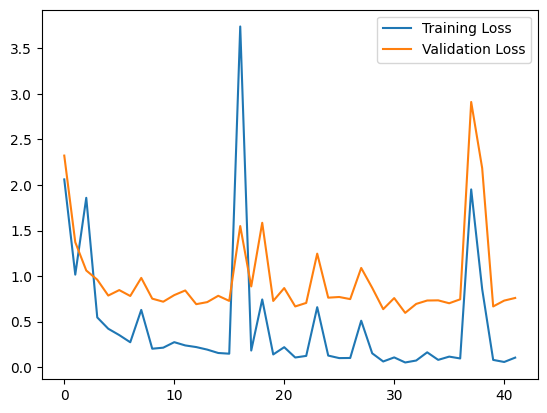

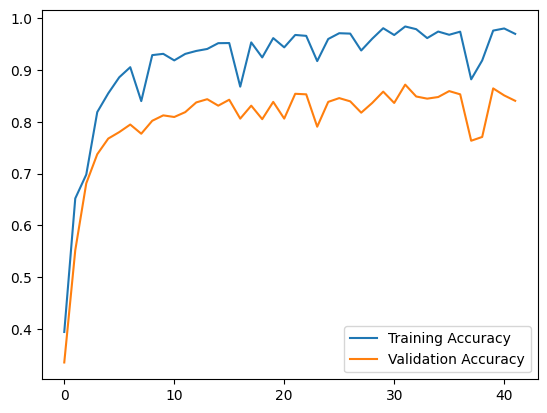

In [15]:
#plot learning curves
plt.figure()
plt.plot(step2_training_losses, label='Training Loss')
plt.plot(step2_validation_losses, label='Validation Loss')
plt.legend()
plt.savefig(os.path.join(output_path, "step2_loss.png"))

plt.figure()
plt.plot(step2_training_accuracies, label='Training Accuracy')
plt.plot(step2_validation_accuracies, label='Validation Accuracy')
plt.legend()
plt.savefig(os.path.join(output_path, "step2_accuracy.png"))

In [16]:
preds, true, _ = evaluate(test_dataloader, step2_best_model, loss_fn)
print("Test accuracy: ", np.mean(preds == true))

Test accuracy:  0.8447916666666667
